In [1]:
#installing requirements
!pip install -r ../requirements.txt



[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Detecting Kermit and Waldorf & Statler based on visual features

This document documents our approach to detect Kermit and Waldorf and Statler based on visual feature engineering. 
We employ a support vector machine classifier to predict the characters based on different visual-engineering features used for character detection.

Time Sheet for this Notebook
Alina Ehart
todo: insert time sheet

In [5]:
#imports
%load_ext autoreload
%autoreload 2
import os
import json
import matplotlib.pyplot as plt
import librosa.feature as lf
import librosa
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_recall_curve, roc_curve, auc
import numpy as np
from skimage.io import imread
from skimage import feature
from tqdm import tqdm


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    average_precision_score,
    accuracy_score,
)


import sys

sys.path.append("..")
from utils.MuppetDataset import MuppetDataset
from utils.visual_evaluation import (
    plot_confusion_matrix,
    plot_roc_curve,
    plot_precision_recall_curve,
    plot_global_confusion_matrix,
)

Loading the data
Set booleans to extract the audio/frames from the .avi files, if it has not been done previously. 

In [3]:
#setting variables for creating muppet dataset
#both set to false as the data is already extracted
extract_audio = False
extract_frames = False

In [6]:
#creating muppetdataset including frames & annotations
video_paths = [
    "../data/Muppets-02-01-01.avi",
    "../data/Muppets-02-04-04.avi",
    "../data/Muppets-03-04-03.avi",
]
annotation_paths = [
    "../data/GroundTruth_Muppets-02-01-01.csv",
    "../data/GroundTruth_Muppets-02-04-04.csv",
    "../data/GroundTruth_Muppets-03-04-03.csv",
]

dataset = MuppetDataset(video_paths, annotation_paths, extract_audio, extract_frames)

example for handling the data for video 0:

dataset.audio_paths[0]
dataset.audios[0]
dataset.annotations.loc[dataset.annotations.Video == 0]

Visual Feature Extraction
The annotations are at the video frame level. Therefore, we need to compute and extract the visual features on frame level as well. We have 25 frames per second.

In [7]:
# Sanity check of frame extraction
for i in range(3):
    number_annotated_frames = (
        dataset.annotations.loc[dataset.annotations["Video"] == i].Frame_number.max()
        + 1
    )
    number_extracted_frames = len(
        [
            item
            for item in os.listdir(f"../data/video/{i}")
            if os.path.isfile(os.path.join(f"../data/video/{i}", item))
        ]
    )
    assert number_annotated_frames == number_extracted_frames

Visual Feature 1 - Predominant Color
For simplicity's sake, we begin with extracting the predominant color of each frame and try to predict character presence on its basis.
With the random training / test split and SVM as classifier this turned out to work pretty well. For the ROC-curve of Kermit I forgot to change the title, that's why it says "Pigs". 
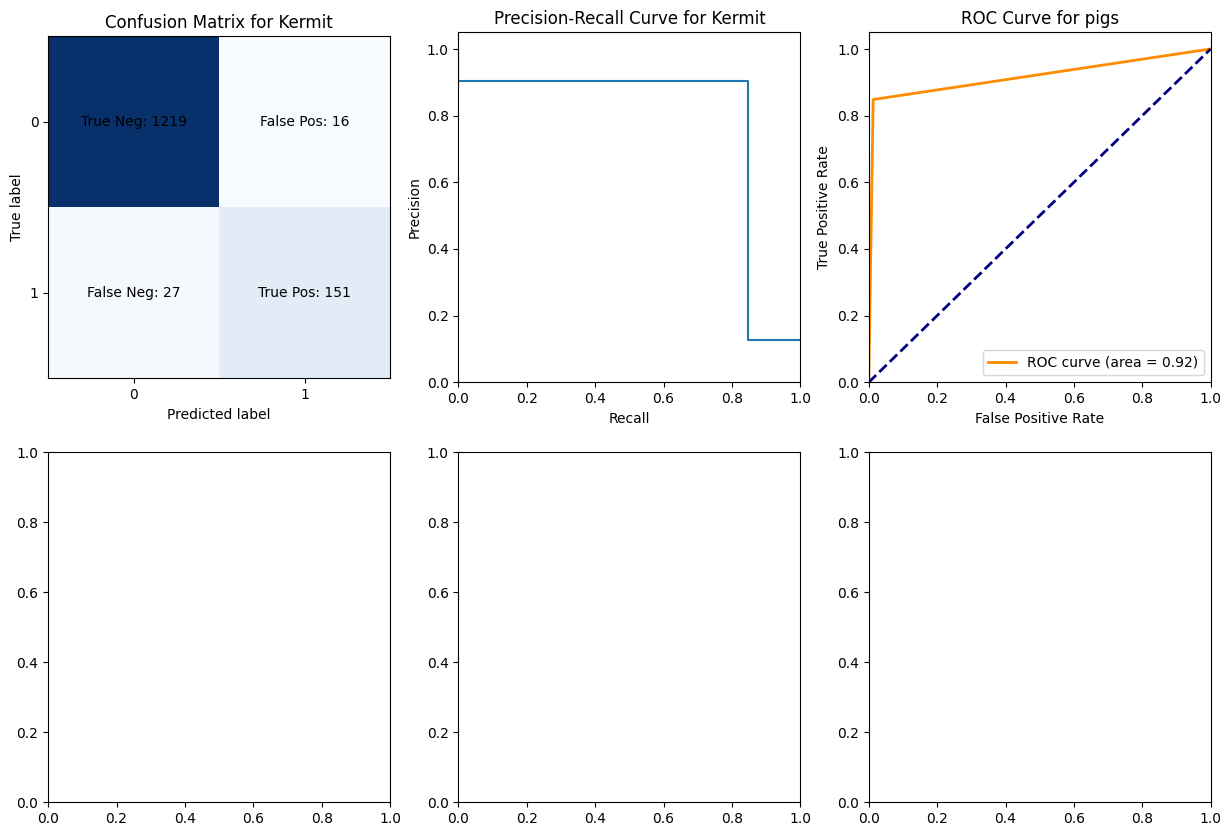
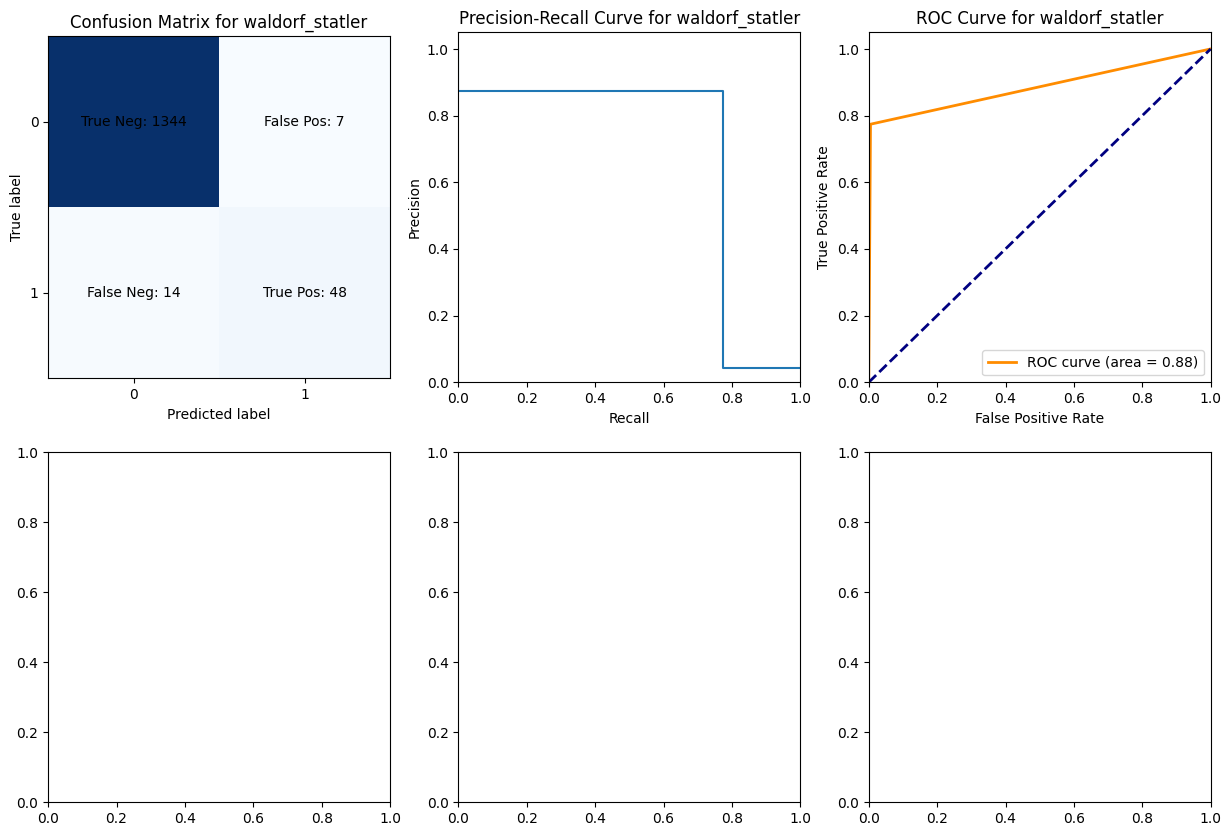


In [8]:
#visual feature extraction
#predominant colour
def get_dominant_color(image):
    pixels = np.float32(image.reshape(-1, 3))
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 200, 0.2)
    _, _, center = cv2.kmeans(pixels, 1, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    dominant_color = center[0].astype(np.uint8)
    return dominant_color

Visual Feature 2 - HOG Features
As a second feature we chose HOG (histogram of oriented gradients), which widely is used for object recognition in images on basis of texture features. 
We tried a lot of parameter tweaking and had to go for a trade off between granularity and resource effiency. We ended up with parameters producing results like the following: 
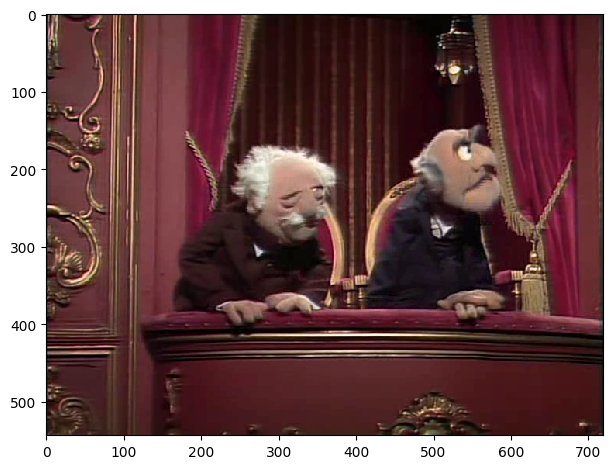
First, we had to reduce the image's resolution to a quater and convert it to grayscale-like. For the pixels per cell 16 x 16 turned out to be a good trade-off. We also tried to go for 32x32 and 64x64 which for sure produced better results, however, the amount of features in the feature vector increased drastically and hence could not be processed by our laptops in a decent amout of time.
todo: eventuell vergleichsbilder einfügen; bild für kermit einfügen
nur damit trainieren und predicten

In [16]:
#visual feature extraction
#hog features
from skimage.io import imread, imshow
from skimage.feature import hog
from skimage import exposure
from cv2 import resize

def get_hog_features(image):
    #resizing image to one quater to speed up processing
    image = cv2.resize(image, (image.shape[1]//4,image.shape[0]//4))
    
    #convert image to gray scale
    img_gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    #creating hog features
    fd, hog_image = hog(img_gray, orientations=9, pixels_per_cell=(16, 16
                                                               ),
    cells_per_block=(2, 2), visualize=True, feature_vector=True)

    # Create a HOG descriptor
    hog_descriptor = cv2.HOGDescriptor()
    # Compute HOG features
    features = hog_descriptor.compute(img_gray)
    #return hog features
    return features





Visual Feature 3 - Edge Features
Edge detection aims to identify boundaries within an image, e.g., where significant changes in intesity or color occur. We anticipate to thereby we able to detect characters by their outlines. Again, the image needs to be converted to grayscale and a gaussian blur is applied to reduce noise. The canny edge detector extracted the following edges from a sample frame: 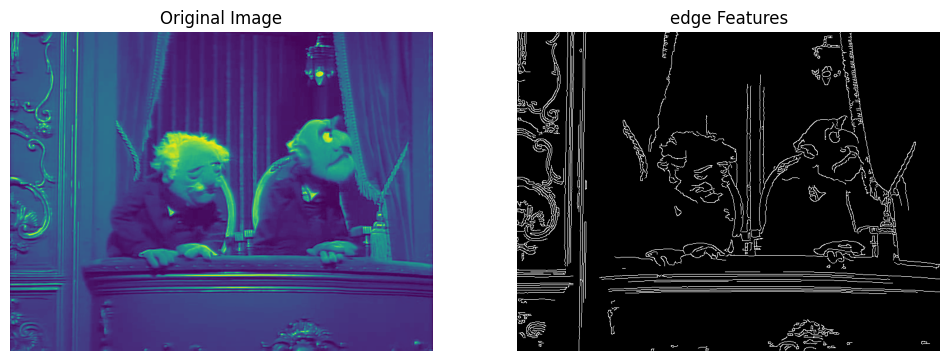
todo: pic for kermit as well
As one can see, the characters a still clearly recognizable. 

In [ ]:
#edge detection 
def get_edge_detection(image):
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply Gaussian blur to the grayscale image
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)

    # Apply Canny edge detector
    edges = cv2.Canny(blurred, 50, 150)
    edge_features = edges.reshape(-1)

    return edge_features

Feature Extraction & Annotation
In the following code block, we extract the visual features from each frame and save them for later usage. We also add the annotions for each frame - regarding which characters are present within each frame.

In [25]:
#feature extractiong & saving to csv file for later usage
import csv
csv_file = 'VisualData.csv'
write_header = not os.path.exists(csv_file)
np.set_printoptions(threshold=np.inf)  # Set the threshold to infinity
#setting up columns for csv file
columns = ['video_id', 'frame_id', 'kermit_present', 'waldorf_statler_present', 'predominant_color', 'hog_features']

dataset.video_features = {}
for video_idx in dataset.frames.keys():
    for frame_idx, frame_path in tqdm(
        dataset.frames[video_idx],
        desc = "Extracting visual features for video {}".format(video_idx),
        leave=False,
    ):
        frame_path = "../data/video/" + str(video_idx)+"/frame_"+str(frame_idx)+".png"
        frame = cv2.imread(frame_path)
        predominant_color = get_dominant_color(frame)
        hog_features = get_hog_features(frame)
        
        #add features to dataframe
        if video_idx not in dataset.video_features:
            dataset.video_features[video_idx]={}
            dataset.video_features[video_idx]["frames"] = {}
        dataset.video_features[video_idx]["frames"][frame_idx]={
            "predominant_color": predominant_color,
            "hog_features":     hog_features
        }
        #add row to csv file
        # row =  {'video_id':video_idx,
        #         'frame_id': frame_idx,
        #         #        dataset.annotations.loc[dataset.annotations["Video"] == i].Frame_number.max()

        #         'kermit_present': dataset.annotations[(dataset.annotations['Video'] == video_idx) & (dataset.annotations['Frame_number'] == frame_idx)]['Kermit'].iloc[0],
        #         'waldorf_statler_present': dataset.annotations[(dataset.annotations['Video'] == video_idx) & (dataset.annotations['Frame_number'] == frame_idx)]['StatlerWaldorf'].iloc[0],
        #         'predominant_color': predominant_color,
        #         'hog_features': hog_features
        #         }
        # with open(csv_file, 'a',newline='') as csvfile:
        #     csv_writer = csv.DictWriter(csvfile, fieldnames=columns)

        #     if write_header:
        #         csv_writer.writeheader()
        #         write_header=False
        #     csv_writer.writerow(row)

Extracting visual features for video 0:  11%|█         | 4206/38681 [7:31:30<75:56:12,  7.93s/it] 

In [22]:
print(dataset.annotations)

        Video  Frame_number  Kermit  Pigs  Audio_Pigs  Cook  Audio_Cook  \
0           0             0       0     0           0     0           0   
1           0             1       0     0           0     0           0   
2           0             2       0     0           0     0           0   
3           0             3       0     0           0     0           0   
4           0             4       0     0           0     0           0   
...       ...           ...     ...   ...         ...   ...         ...   
115880      2         38493       0     0           0     0           0   
115881      2         38494       0     0           0     0           0   
115882      2         38495       0     0           0     0           0   
115883      2         38496       0     0           0     0           0   
115884      2         38497       0     0           0     0           0   

        StatlerWaldorf  Audio_StatlerWaldorf  Audio_MissPiggy  
0                    0             